In [1]:
import torch

In [11]:
class Polynomial(torch.nn.Module):
    def __init__(self, order):
        super().__init__()
        self.order = order
        self.coef = torch.nn.Parameter(torch.zeros(order + 1))

    def forward(self, x:torch.Tensor):
        out = self.coef[0]
        for i in range(1, self.order + 1):
            out = out + self.coef[i] * x.pow(i)
        return out

xvalues = torch.tensor([5, 4.99, 4.9])
yvalues = torch.tensor([25, 24.9, 24.01])
pol = Polynomial(2)
opt = torch.optim.AdamW(pol.parameters(), lr=1e-1)
loss = float('inf')
tol = 1e-1
while loss > tol:
    opt.zero_grad()
    preds = pol(xvalues)
    loss = torch.nn.functional.mse_loss(preds,yvalues)
    print(float(loss))
    loss.backward()
    #torch.nn.utils.clip_grad_value_(pol.parameters(), 10.)
    opt.step()

607.1633911132812
465.709228515625
343.739013671875
241.3648681640625
158.4280242919922
94.41390991210938
48.35988235473633
18.770994186401367
3.5698769092559814
0.11640352755784988
5.330383777618408
15.92824935913086
28.742034912109375
41.04737091064453
50.81399154663086
56.8219108581543
58.63630294799805
56.477752685546875
51.03914260864258
43.29364013671875
34.32125473022461
25.166696548461914
16.732446670532227
9.705477714538574
4.516177654266357
1.3275948762893677
0.05292033031582832


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


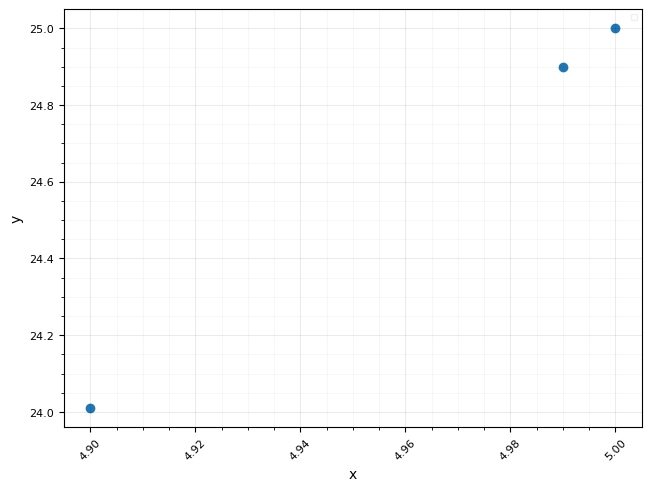

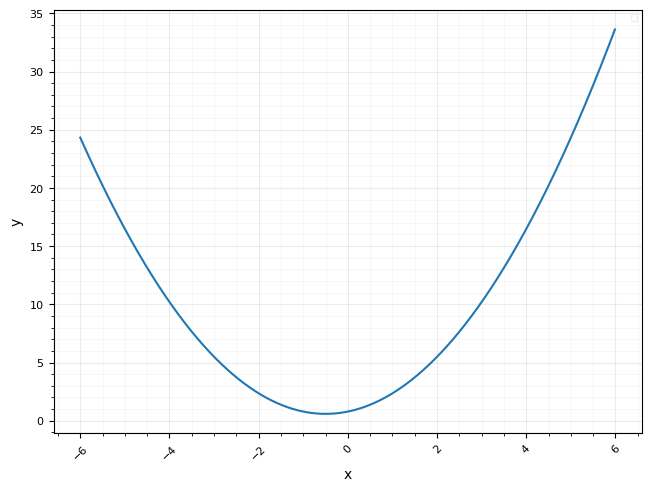

In [12]:
from glio.plot import *
qscatter(xvalues, yvalues)
qfuncplot1d(pol, -6, 6, 1000, vectorize='torch')

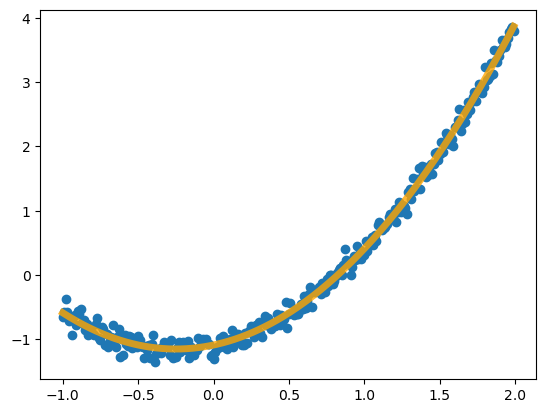

In [32]:
import torch
import matplotlib.pyplot as plt

## We won't need any gradients here
torch.set_grad_enabled(False)

# Generate some test data
x = torch.arange(-1, 2, 0.01)
# Define our test function
y = (x * x) + (0.5 * x) - 1.1
# Add some noise to the data
y += torch.randn_like(x) * 0.1

# Create some features
X = torch.stack([
    x,
    x**2,
    torch.ones_like(x)  # bias
]).T
# Fit to data
W = torch.linalg.lstsq(X, y.unsqueeze(-1)).solution
pred = (X @ W)


plt.scatter(x, y)
plt.plot(x, pred, c='orange', linewidth=5, alpha=0.8)
plt.show()


In [124]:
@torch.no_grad
def fit_quadratic(x, y, driver=None):
    X = torch.stack([x**2, x, torch.ones_like(x)]).T
    W = torch.linalg.lstsq(X, y, driver=driver).solution
    def quadratic(x):
        X = torch.stack([x**2, x, torch.ones_like(x)]).T
        return X @ W
    return quadratic

@torch.no_grad
def find_quadratic_coefficients(x, y):
    """Returns a tensor with a, b and c in `f(x) = ax^2 + bx + c`"""
    X = torch.stack([x**2, x, torch.ones_like(x)]).T
    W = torch.linalg.lstsq(X, y).solution
    return W

@torch.no_grad
def fit_quadratic_minimum(x, y):
    X = torch.stack([x**2, x, torch.ones_like(x)]).T
    W = torch.linalg.lstsq(X, y).solution # a, b, c
    return - W[1] / (2 * W[0])

In [100]:
@torch.no_grad
def fit_cubic(x, y, driver=None):
    X = torch.stack([x**3, x**2, x, torch.ones_like(x)]).T
    W = torch.linalg.lstsq(X, y, driver=driver).solution
    def cubic(x):
        X = torch.stack([x**3, x**2, x, torch.ones_like(x)]).T
        return X @ W
    return cubic

In [104]:
for i in range(2, 1): print(i)

In [205]:
@torch.no_grad
def fit_polynomial(x, y, degree, rcond=None, driver=None):
    X = torch.stack([torch.ones_like(x), x] + [x**i for i in range(2, degree+1)]).T
    W = torch.linalg.lstsq(X, y, rcond = rcond, driver=driver).solution
    def polynomial(x):
        X = torch.stack([torch.ones_like(x), x] + [x**i for i in range(2, degree+1)]).T
        return X @ W
    return polynomial

import numpy as np
import scipy.linalg
def fit_polynomial_np(x, y, degree, rcond=None):
    X = np.stack([np.ones_like(x), x] + [x**i for i in range(2, degree+1)]).T
    W = np.linalg.lstsq(X, y, rcond = rcond)[0]
    def polynomial(x):
        X = np.stack([np.ones_like(x), x] + [x**i for i in range(2, degree+1)]).T
        return X @ W
    return polynomial

def fit_polynomial_scipy(x, y, degree, rcond=None):
    X = np.stack([np.ones_like(x), x] + [x**i for i in range(2, degree+1)]).T
    W = scipy.linalg.lstsq(X, y, cond = rcond)[0]
    def polynomial(x):
        X = np.stack([np.ones_like(x), x] + [x**i for i in range(2, degree+1)]).T
        return X @ W
    return polynomial


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


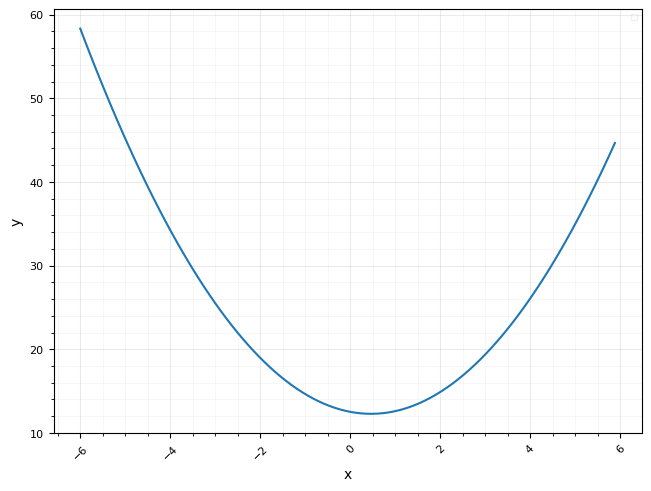

In [269]:
polynomial = fit_polynomial(torch.tensor([5, 4.99, 4.9]), torch.tensor([25, 24.9, 4.9**2])+10, 2)
qfuncplot1d(polynomial, -6, 6, 100, vectorize='torch')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


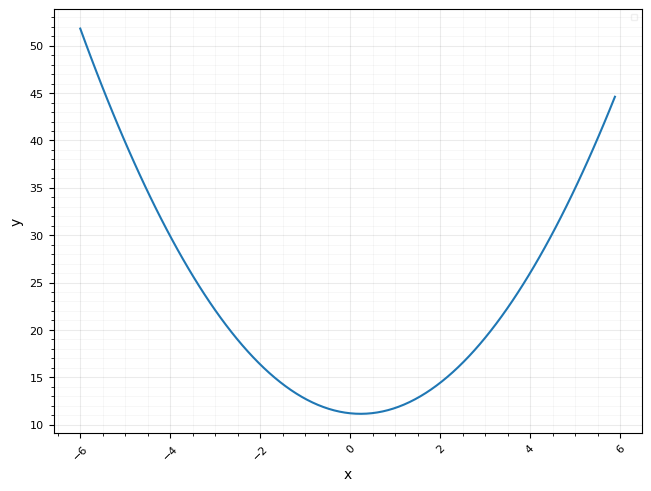

In [274]:
def fit_polynomial_np2(x, y, degree):
    polynomial = np.polynomial.Polynomial.fit(x, y, degree)
    return polynomial
polynomial = fit_polynomial_np2(torch.tensor([5, 4.999, 4.9]), torch.tensor([25, 24.99, 4.9**2])+10, 2)
qfuncplot1d(polynomial, -6, 6, 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


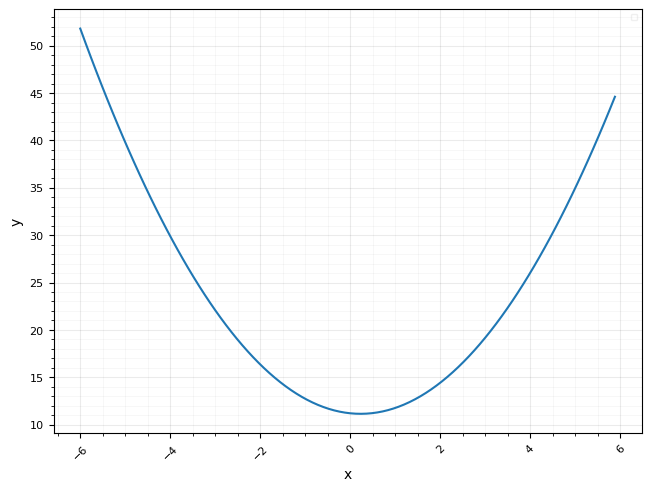

In [275]:
def fit_chebushev_np(x, y, degree):
    chebyshev = np.polynomial.chebyshev.Chebyshev.fit(x, y, degree)
    return chebyshev
chebyshev = fit_chebushev_np(torch.tensor([5, 4.999, 4.9]), torch.tensor([25, 24.99, 4.9**2])+10, 2)
qfuncplot1d(chebyshev, -6, 6, 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


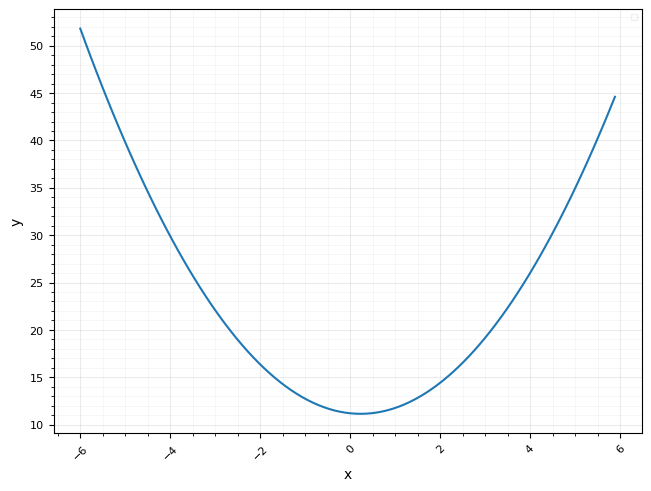

In [276]:
def fit_legendre_np(x, y, degree):
    legendre = np.polynomial.legendre.Legendre.fit(x, y, degree)
    return legendre
legendre = fit_legendre_np(torch.tensor([5, 4.999, 4.9]), torch.tensor([25, 24.99, 4.9**2])+10, 2)
qfuncplot1d(legendre, -6, 6, 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


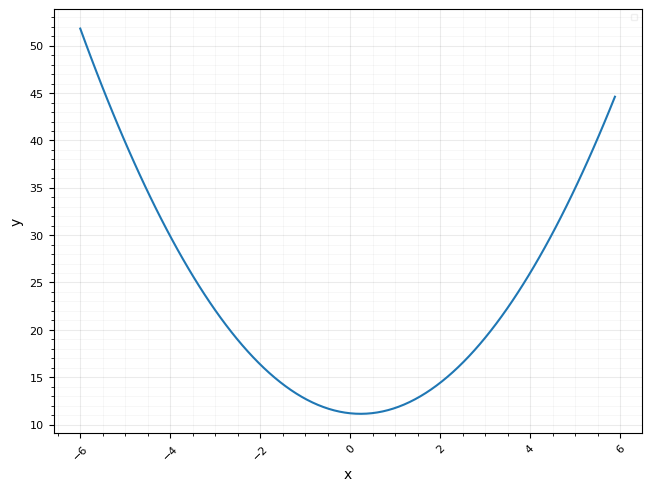

In [277]:
def fit_laguerre_np(x, y, degree):
    laguerre = np.polynomial.laguerre.Laguerre.fit(x, y, degree)
    return laguerre
laguerre = fit_laguerre_np(torch.tensor([5, 4.999, 4.9]), torch.tensor([25, 24.99, 4.9**2])+10, 2)
qfuncplot1d(laguerre, -6, 6, 100)   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


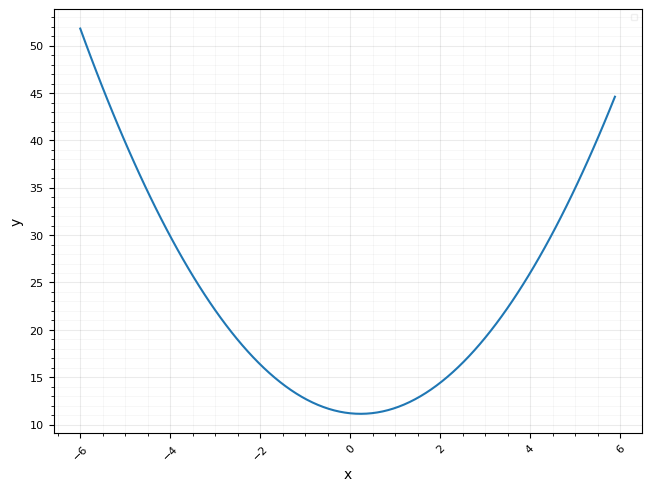

In [278]:
def fit_laguerre_np(x, y, degree):
    laguerre = np.polynomial.laguerre.Laguerre.fit(x, y, degree)
    return laguerre
laguerre = fit_laguerre_np(torch.tensor([5, 4.999, 4.9]), torch.tensor([25, 24.99, 4.9**2])+10, 2)
qfuncplot1d(laguerre, -6, 6, 100)   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


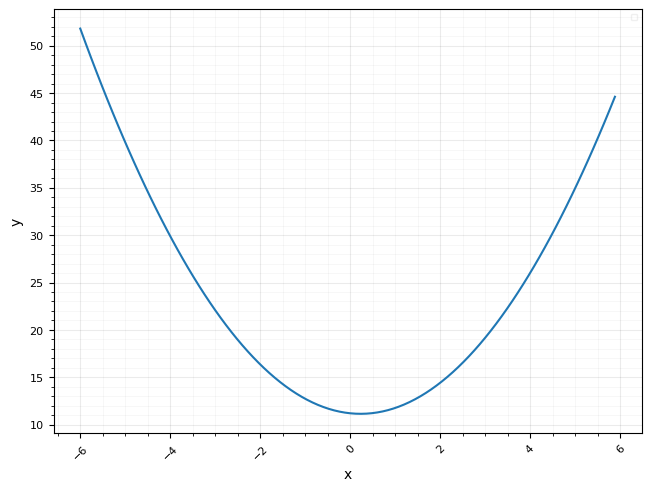

In [279]:
def fit_hermite_np(x, y, degree):
    hermite = np.polynomial.hermite.Hermite.fit(x, y, degree)
    return hermite
hermite = fit_hermite_np(torch.tensor([5, 4.999, 4.9]), torch.tensor([25, 24.99, 4.9**2])+10, 2)
qfuncplot1d(hermite, -6, 6, 100)   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


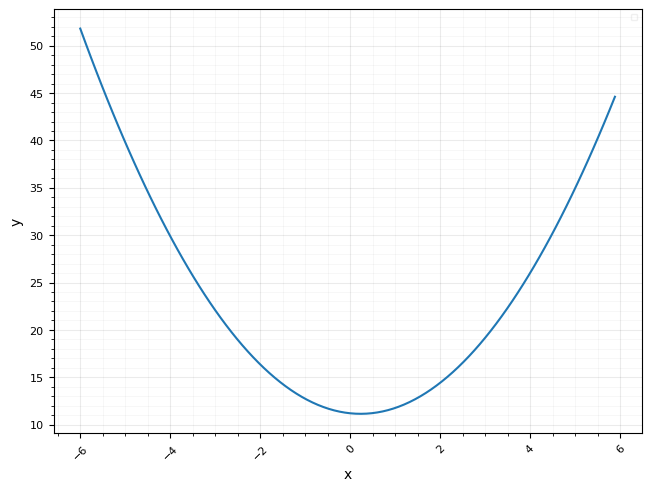

In [280]:
def fit_hermiteE_np(x, y, degree):
    hermiteE = np.polynomial.hermite_e.HermiteE.fit(x, y, degree)
    return hermiteE
hermiteE = fit_hermiteE_np(torch.tensor([5, 4.999, 4.9]), torch.tensor([25, 24.99, 4.9**2])+10, 2)
qfuncplot1d(hermiteE, -6, 6, 100)   

In [283]:
hermiteE.roots()

array([0.22897863-3.2585633j, 0.22897863+3.2585633j], dtype=complex64)

In [288]:
def fit_polynomial_np(x, y, degree):
    polynomial = np.polynomial.Polynomial.fit(x, y, degree)
    return polynomial
polynomial = fit_polynomial_np(torch.tensor([5, 4.9999, 4.9]), torch.tensor([25, 24.999, 4.9**2])+10, 2)

def fit_quadratic_minimum_np(x, y):
    coeffs = np.polynomial.Polynomial.fit(x, y, 2).coef
    return - coeffs[1] / (2 * coeffs[0])

fit_quadratic_minimum_np(torch.tensor([5, 4.9999, 4.9]), torch.tensor([25, 24.999, 4.9**2]))

-0.010101046467067304